In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

import os 
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/4_job/medium_fake_news_detection')

Mounted at /content/gdrive


In [ ]:
from IPython.display import clear_output

!pip install transformers datasets sentence_transformers

clear_output(wait=False)

In [ ]:
import numpy as ny
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# !pip install datasets
from datasets import load_dataset

dataset = load_dataset("health_fact")

Using custom data configuration default


Generating train split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1225 [00:00<?, ? examples/s]

Dataset health_fact downloaded and prepared to /root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset.keys()

dict_keys(['train', 'test', 'validation'])

In [ ]:
df_dataset = pd.concat([pd.DataFrame.from_dict(dataset['train'], orient='columns'),
                        pd.DataFrame.from_dict(dataset['test'], orient='columns'), 
                        pd.DataFrame.from_dict(dataset['validation'], orient='columns')])

In [ ]:
len(df_dataset)

12292

In [ ]:
# #NOTE: There are missing labels in the dataset which was replaced with -1.
# #Here, I removed those data entries
df_dataset = df_dataset[df_dataset.label != -1]
df_dataset = df_dataset.reset_index()
len(df_dataset)

12251

Label class:
*   0: False
*   1: Mixture
*   2: True
*   3: Unproven



In [ ]:
df_dataset.label.value_counts()

2    6306
0    3769
1    1799
3     377
Name: label, dtype: int64

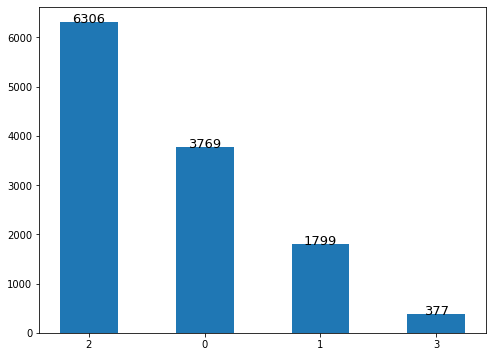

In [ ]:
import matplotlib.pyplot as plt
# function to add value labels
def addlabels(x,y):
  for i, l in enumerate(x):
    plt.text(i, y[int(l)], y[int(l)], ha = 'center', fontsize=13)

fig, ax = plt.subplots(figsize = (8,6))
labs = [str(i) for i in df_dataset.label.value_counts().index]
cnt = df_dataset.label.value_counts()

ax.bar(labs, cnt, width=0.5)
# calling the function to add value labels
addlabels(labs, cnt)
plt.show()

In [ ]:
#Split the dataset
x_train,x_test,y_train,y_test=train_test_split(df_dataset.claim, df_dataset.label, test_size=0.15, random_state=8)

### 1. Baseline
Featurization: TF-IDF

Classifier: PassiveAggressive

In [ ]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.65)
tfidf_train=tfidf_vectorizer.fit_transform(x_train)
tfidf_test=tfidf_vectorizer.transform(x_test)

In [ ]:
pclass=PassiveAggressiveClassifier(max_iter=60)
pclass.fit(tfidf_train,y_train)
y_pred=pclass.predict(tfidf_test)
factcheckscore=accuracy_score(y_test,y_pred)
print(f'Fact-check Accuracy Is {round(factcheckscore*100,2)}%')

Fact-check Accuracy Is 52.18%


In [ ]:
len(x_train)

10413

In [ ]:
pd.DataFrame(y_pred).value_counts()

2    1022
0     550
1     236
3      30
dtype: int64

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
RANDOM_SEED = 42
MAX_LEN = 60
BATCH_SIZE = 32
EPOCHS = 10

#trainX, testX, trainy, testy = train_test_split(features, labels, test_size=0.5, random_state=2, stratify=labels)

# dataset for conventional ML models
# X_train, X_test, y_train, y_test = train_test_split(features, labels,
#                                                     stratify=labels, 
#                                                     test_size=0.3)

# dataset for BERT model
# df_train, df_test = train_test_split(df, 
#                                      test_size=0.3, 
#                                      random_state = RANDOM_SEED)
# df_val, df_test = train_test_split(df_test,
#                                    test_size=0.5, 
#                                    random_state = RANDOM_SEED)
# # X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(df.text, df.category_id, df.index, test_size=0.3, random_state=0)

# train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
# val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
# test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
# all_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    #MultinomialNB(),
    LogisticRegression(random_state=0),
    XGBClassifier(random_state=1)
]

entries = []
best_accuracy = 0
for model in models:
    model_name = model.__class__.__name__
    model.fit(tfidf_train, y_train)
    y_pred = model.predict(tfidf_test)
    accuracies = accuracy_score(y_test, y_pred)
    #accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    #accuracies = cross_val_score(model, resampled_features, resampled_labels, scoring='accuracy', cv=CV)
    #for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, accuracies))
    if accuracies > best_accuracy:
        
        best_accuracy = accuracies
        print('best model created:',model_name)
cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])

print(cv_df.groupby('model_name').accuracy.mean())

#model = LinearSVC()
# model = LogisticRegression()
# model.fit(x_train, y_train)
# y_pred = model.predict(x_test)
#model = MultinomialNB()
#model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=1)
#model = XGBClassifier(random_state=1)

# target_names = ['neutral_comment', 'complaint','compliment','appreciation','suggestion']
print(classification_report(y_test, y_pred))

best model created: RandomForestClassifier
best model created: LinearSVC


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


best model created: LogisticRegression
model_name
LinearSVC                 0.570729
LogisticRegression        0.586507
RandomForestClassifier    0.516866
XGBClassifier             0.551143
Name: accuracy, dtype: float64
              precision    recall  f1-score   support

           0       0.57      0.19      0.29       542
           1       0.00      0.00      0.00       285
           2       0.55      0.96      0.70       950
           3       0.00      0.00      0.00        61

    accuracy                           0.55      1838
   macro avg       0.28      0.29      0.25      1838
weighted avg       0.45      0.55      0.45      1838



## 3. BERT

In [ ]:
from torch.utils.data import Dataset, DataLoader

MAX_LEN = 60
BATCH_SIZE = 32
EPOCHS = 10


class AnswerDataset(Dataset):
  #constructor - target: sentiment
  def __init__(self, claims, labels, tokenizer, max_len):
    self.clms = claims
    self.labs = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  #1. how large the dataset is.
  #returns the number of answers we have
  def __len__(self):
    return len(self.clms)

  #2. takes the index of element from the dataset
  #returns 
  def __getitem__(self, item):
    clms = str(self.clms[item])
    labs = self.labs[item]
    
    encoding = self.tokenizer.encode_plus(
      claims,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'claim_text': claims,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(labels, dtype=torch.long)
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = AnswerDataset(
      claims = df.claim.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4
  )


In [ ]:
df_train, df_test = train_test_split(df_dataset, 
                                     test_size=0.3, 
                                     random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test,
                                   test_size=0.5, 
                                   random_state = RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape, df_dataset.shape

((8575, 10), (1838, 10), (1838, 10), (12251, 10))

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids = input_ids,
      attention_mask = attention_mask
    )
    output = self.drop(pooled_output)
    
    #returning the raw output of the last layer since
    #that is required for the cross-entrophy loss function in PyTorch
    return self.out(output)

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
print(bert_model.config.hidden_size)


BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
all_data_loader = create_data_loader(df_dataset, tokenizer, MAX_LEN, BATCH_SIZE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


768


In [ ]:

model = SentimentClassifier(5)#.to(device)
#model.load_state_dict(torch.load('best_model_state.bin'))
#model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#In the training history graph below, after EPOCH=5, the model
#seems to be overfitting. So here I will set it to 5
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()#.to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  #device,
  scheduler,
  n_examples
  ):

  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    #device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    #device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


NameError: ignored

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
from tqdm import tqdm


import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
path = "C:\\Users\\kongb\\AppData\\Local\\Microsoft\\Windows\\Fonts\\AppleGothic.ttf"
fontprop = fm.FontProperties(fname=path, size=18)

def viz_vectors(target_vectors, annotation = False):
    x = []
    y = []
    for value in target_vectors[:10000]:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16)) 
    plt.rc('font', family='NanumMyeongjo')
    for i in tqdm(range(len(x))):
        plt.scatter(x[i],y[i])
        if annotation == True:
            plt.annotate(targets[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom',
                         fontproperties=fontprop)

    plt.show()